In [1]:
# Imported all modules I would need.
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import spacy

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Obtained spanish stop words list from: https://github.com/stopwords-iso/stopwords-es/blob/master/stopwords-es.txt
# Obtained guidance on creating stop_words_list using .txt file from: https://stackoverflow.com/questions/36369870/sklearn-how-to-add-custom-stopword-list-from-txt-file#36371942
with open('spanish.txt') as file:
    spanish = file.read().split()
    
with open('spanish_politics.txt') as file:
    spanish_politics = file.read().split()

In [4]:
spanish[:20]

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '_',
 'a',
 'actualmente',
 'acuerdo',
 'adelante',
 'ademas',
 'además',
 'adrede',
 'afirmó',
 'agregó']

In [5]:
spanish_politics[-20:]

['pt',
 'trabajo',
 'pv',
 'verde',
 'ecologista',
 'sen',
 'dip',
 'karencastrejont',
 'mc',
 'movimiento',
 'ciudadano',
 'elfuturoesnaranja',
 'bancadanaranja',
 'pablo_vah',
 'clementech',
 'mrn',
 'lopezobrador_',
 'conferenciapresidente',
 '22',
 'amlo']

In [6]:
# !python -m spacy download es_core_news_sm

In [7]:
# Obtained Spanish-langauge lemmatizer function from: https://spacy.io/models/es
nlp = spacy.load('es_core_news_sm')

def lemma_tokenizer(doc):
    return [i.lemma_ for i in (nlp(doc))]

In [8]:
# Obtained Spanish-langauge stemming function from: https://stackoverflow.com/questions/26292453/how-to-stem-a-list-of-words-in-spanish-with-nltk#26294198

def stemming_tokenizer(doc):
    stemming = SnowballStemmer('spanish')
    return [stemming.stem(w) for w in word_tokenize(doc)]

In [9]:
# Set notebook's random seed to 42.
np.random.seed(42)

# **Preprocessing**

In [10]:
# Created a DataFrame from the mx_political.csv file, which contained the cleaned data.
# mx_political_df = pd.read_csv('../data/mx_political.csv')
mx_political_df = pd.read_csv('mx_political.csv')


In [11]:
mx_political_df.tail()

,user,tweet
19164,PartidoMorenaMx,RT @DiputadosMorena: Abajo el patriarcado #NiU...
19165,PartidoMorenaMx,RT @DiputadosMorena: Hartas de violencias mach...
19166,PartidoMorenaMx,"RT @DiputadosMorena: Vivas, libres y en lucha ..."
19167,PartidoMorenaMx,"RT @DiputadosMorena: No nos sentimos seguras, ..."
19168,PartidoMorenaMx,RT @DiputadosMorena: Luchamos hoy para no mori...


In [12]:
# Defined my one feature, the target vector, and proceed to perform a train/test split with a random_state of 42 while stratifying on the label.
X = mx_political_df['tweet']
y = mx_political_df['user']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [13]:
# Looked at the noramlized value_counts in the target vector.
y.value_counts(normalize=True)

partidoverdemex    0.166936
PRI_Nacional       0.166884
AccionNacional     0.166832
PartidoMorenaMx    0.166780
PRDMexico          0.166519
MovCiudadanoMX     0.166049
Name: user, dtype: float64

# **Modeling**

## **Baseline Model**

In [ ]:
# Instantiated DummyClassifier object and proceeded to fit it on the X_train and y_train before scoring both X_train/y_train and X_test/y_test.
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_train, y_train), dc.score(X_test, y_test)

(0.1669449081803005, 0.1669100771959107)

In [ ]:
# Utilized the fitted DummyClassifier object to predict the target and saved the results under variable named "baseline_preds".
baseline_preds = dc.predict(X_test)

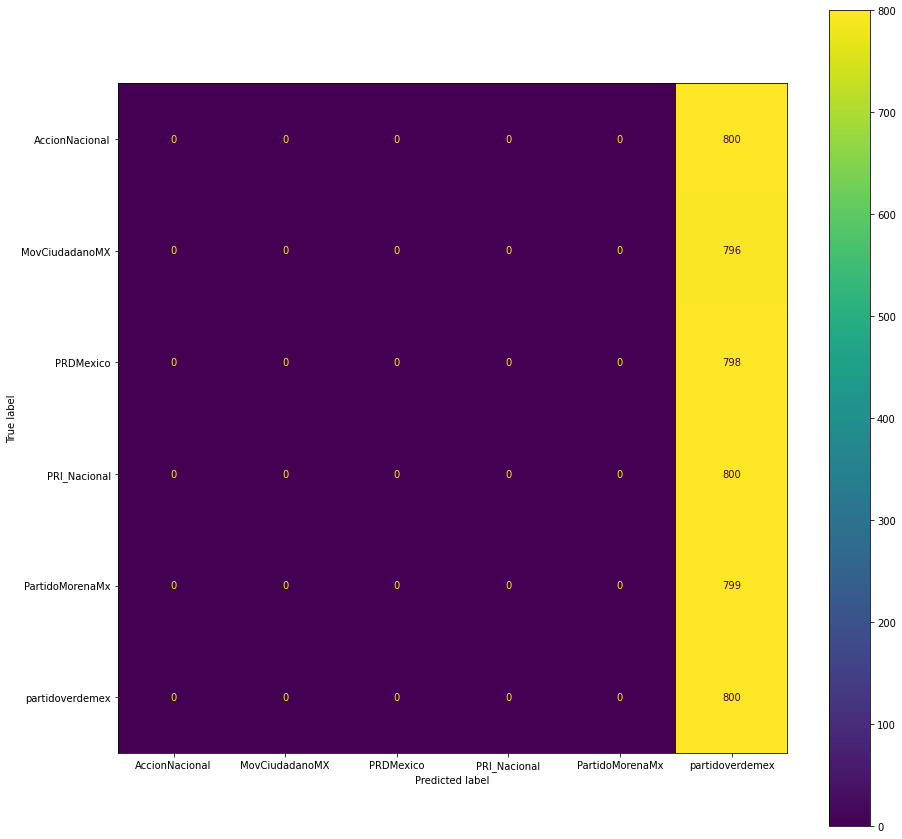

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this DummyClassifier estimator.

# Obtained guidance with adjustig size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(dc, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
baseline_precision = precision_score(y_test, baseline_preds, labels='PartidoMorenaMx', average='macro')
baseline_precision

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.027818346199318448

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
baseline_recall = recall_score(y_test, baseline_preds, labels='PartidoMorenaMx', average='macro')
baseline_recall

0.16666666666666666

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
baseline_f1 = f1_score(y_test, baseline_preds, labels='PartidoMorenaMx', average='macro')
baseline_f1

0.04767864592645569

## **CountVectorizer with Spanish Stop Words**

### CountVectorizer + Logistic Regression

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_logreg_pipe = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10_000))
cvec_logreg_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'logisticregression': LogisticRegression(max_iter=10000),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_logreg_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer], 
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet']
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_logreg_rs = RandomizedSearchCV(cvec_logreg_pipe, param_distributions=cvec_logreg_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_rs.fit(X_train, y_train)
cvec_logreg_rs.score(X_train, y_train), cvec_logreg_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

(0.9955481357818586, 0.8458168161902775)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_logreg_rs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_logreg_new_params = {
    'countvectorizer__ngram_range': [(3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [stemming_tokenizer], 
    'logisticregression__C': [1.0, .8, .6],
    'logisticregression__penalty': ['l2']
}

**Hyperparameter Tuning using GridSearch CV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_logreg_gs = GridSearchCV(cvec_logreg_pipe, param_grid=cvec_logreg_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_gs.fit(X_train, y_train)
cvec_logreg_gs.score(X_train, y_train), cvec_logreg_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic'

(0.9955481357818586, 0.8458168161902775)

In [ ]:
# Utilized the fitted GridSearchCV object to predict the target and saved the results under variable named "cvec_logreg_gs_preds".
cvec_logreg_gs_preds = cvec_logreg_gs.predict(X_test)

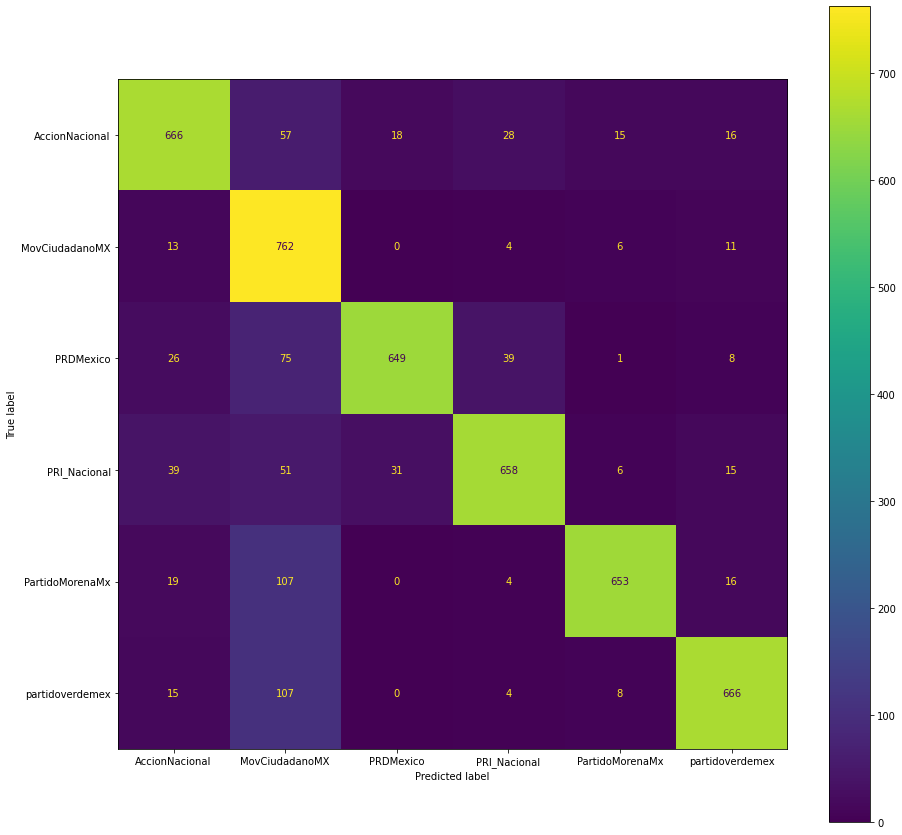

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this Logistic Regression estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_logreg_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_precision = precision_score(y_test, cvec_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_precision

0.86561650012812

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_recall = recall_score(y_test, cvec_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_recall

0.8458902049446188

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_f1 = f1_score(y_test, cvec_logreg_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_f1

0.849107739424856

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_logreg_gs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

### CountVectorizer + KNeighborsClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and KNeighbors classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_knn_pipe = make_pipeline(CountVectorizer(), KNeighborsClassifier())
cvec_knn_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'kneighborsclassifier': KNeighborsClassifier(),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neigh

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_knn_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 5, 10]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_knn_rs = RandomizedSearchCV(cvec_knn_pipe, param_distributions=cvec_knn_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_rs.fit(X_train, y_train)
cvec_knn_rs.score(X_train, y_train), cvec_knn_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar',

(0.7154284919309961, 0.562486960150219)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_knn_rs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_knn_new_params = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'kneighborsclassifier__n_neighbors': [4, 5, 6]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_knn_gs = GridSearchCV(cvec_knn_pipe, param_grid=cvec_knn_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_gs.fit(X_train, y_train)
cvec_knn_gs.score(X_train, y_train), cvec_knn_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufeff1'] not in stop_words.
  % sorted(inconsistent)


(0.7450612131329994, 0.5674942624660964)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_knn_gs_preds".
cvec_knn_gs_preds = cvec_knn_gs.predict(X_test)

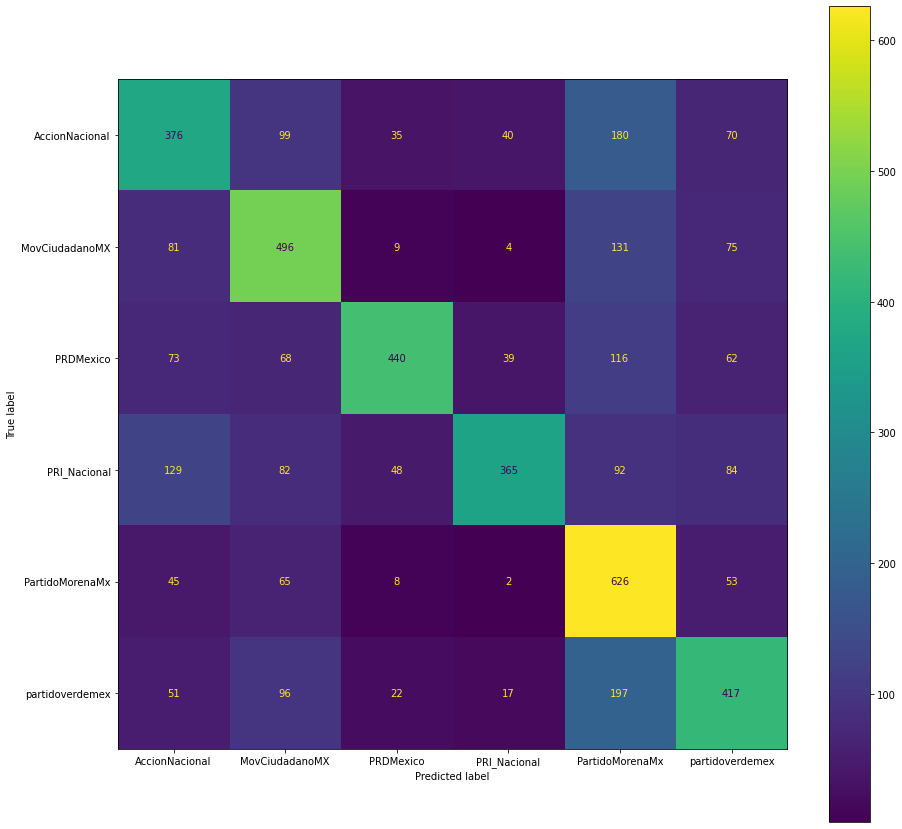

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this KNeighbors Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_knn_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_precision = precision_score(y_test, cvec_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_precision

0.6040680850287612

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_recall = recall_score(y_test, cvec_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_recall

0.5675788955318697

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_f1 = f1_score(y_test, cvec_knn_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_f1

0.5681190604387997

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_knn_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

### CountVectorizer + SVC

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Support Vector Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_svc_pipe = make_pipeline(CountVectorizer(), SVC())
cvec_svc_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'memory': None,
 'steps': [('countvectorizer', CountVectorizer()), ('svc', SVC())],
 'svc': SVC(),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scal

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_svc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'svc__C': [1.0, .1]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_svc_rs = RandomizedSearchCV(cvec_svc_pipe, param_distributions=cvec_svc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_rs.fit(X_train, y_train)
cvec_svc_rs.score(X_train, y_train), cvec_svc_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufeff1'] not in stop_words.
  % sorted(inconsistent)


(0.9750278241513634, 0.8648028374713124)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_svc_rs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_svc_new_params = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'svc__C': [1.0, .9, .8]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_svc_gs = GridSearchCV(cvec_svc_pipe, param_grid=cvec_svc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_gs.fit(X_train, y_train)
cvec_svc_gs.score(X_train, y_train), cvec_svc_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufeff1'] not in stop_words.
  % sorted(inconsistent)


(0.9750278241513634, 0.8648028374713124)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_svc_gs_preds".
cvec_svc_gs_preds = cvec_svc_gs.predict(X_test)

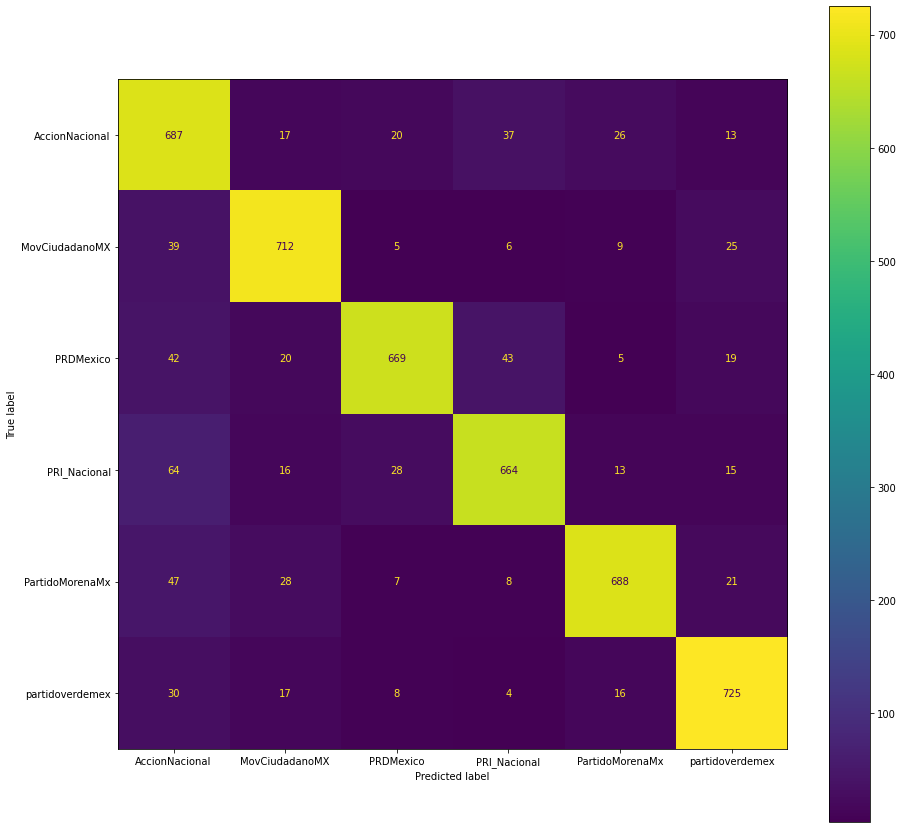

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this SVC estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_svc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_precision = precision_score(y_test, cvec_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_precision

0.86817864189198

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_recall = recall_score(y_test, cvec_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_recall

0.8648157619837482

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_f1 = f1_score(y_test, cvec_svc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_f1

0.8654990130007124

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_svc_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

### CountVectorizer + MultinomialNB

In [33]:
# Created a pipeline object with a CountVectorizer transformer and Multinomial Naives Bayes Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_mnb_pipe = make_pipeline(CountVectorizer(), MultinomialNB())
cvec_mnb_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'memory': None,
 'multinomialnb': MultinomialNB(),
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False}

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_mnb_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'multinomialnb__alpha': [1.0, .5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_mnb_rs = RandomizedSearchCV(cvec_mnb_pipe, param_distributions=cvec_mnb_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_rs.fit(X_train, y_train)
cvec_mnb_rs.score(X_train, y_train), cvec_mnb_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic'

(0.9945742904841403, 0.904652618401836)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_mnb_rs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [19]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_mnb_new_params = {
    'countvectorizer__ngram_range': [(2, 2)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'multinomialnb__alpha': [0.4, 0.5, 0.6]
}

**Hyperparameter Tuning using GridSearchCV**

In [20]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_mnb_gs = GridSearchCV(cvec_mnb_pipe, param_grid=cvec_mnb_new_params, n_jobs=-1)

In [21]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_gs.fit(X_train, y_train)
cvec_mnb_gs.score(X_train, y_train), cvec_mnb_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ejempl', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'except', 'exist', 'explic', 'expres', 'fuer

(0.994852531997774, 0.9040267056123513)

In [22]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_mnb_gs_preds".
cvec_mnb_gs_preds = cvec_mnb_gs.predict(X_test)

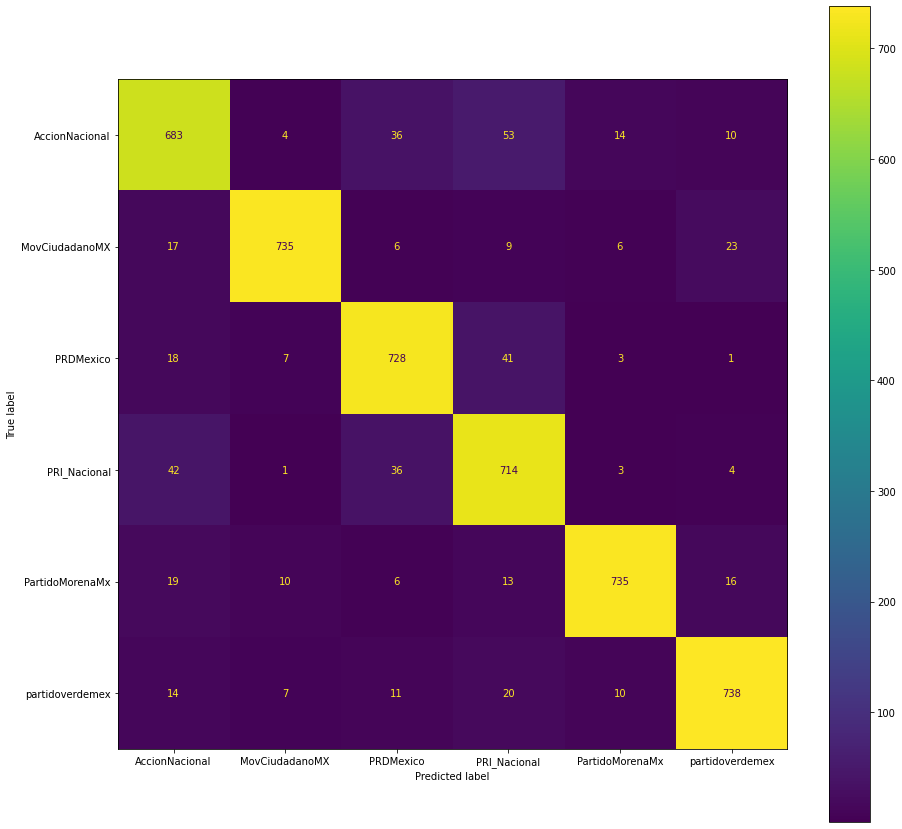

In [23]:
# Generated a ConfusionMatrixDisplay utilizing this MNB Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_mnb_gs, X_test, y_test, ax=ax);

In [24]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_precision = precision_score(y_test, cvec_mnb_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_precision

0.9055037276059571

In [25]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_recall = recall_score(y_test, cvec_mnb_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_recall

0.9040495684614659

In [26]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_f1 = f1_score(y_test, cvec_mnb_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_f1

0.9044860331467088

In [27]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_mnb_gs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [34]:
cvec_mnb_gs.best_estimator_

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(2, 2),
                                 stop_words=frozenset({'0', '1', '2', '3', '4',
                                                       '5', '6', '7', '8', '9',
                                                       '_', 'a', 'actualmente',
                                                       'acuerdo', 'adelante',
                                                       'ademas', 'además',
                                                       'adrede', 'afirmó',
                                                       'agregó', 'ahi', 'ahora',
                                                       'ahí', 'al', 'algo',
                                                       'alguna', 'algunas',
                                                       'alguno', 'algunos',
                                                       'algún', ...}),
                                 tokenizer=<function stemming_t

In [35]:
with open("saved-sk_learn-model.pkl", "wb") as file:
    pickle.dump(cvec_mnb_gs.best_estimator_, file)

### CountVectorizer + DecisionTreeClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Decision Tree Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_dtc_pipe = make_pipeline(CountVectorizer(), DecisionTreeClassifier())
cvec_dtc_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreec

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_dtc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__max_features': [None, 1_000, 2_000],
    'decisiontreeclassifier__min_samples_split': [None, 2, 5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_dtc_rs = RandomizedSearchCV(cvec_dtc_pipe, param_distributions=cvec_dtc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_rs.fit(X_train, y_train) 
cvec_dtc_rs.score(X_train, y_train), cvec_dtc_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pack

(0.9961741791875348, 0.7721677446275819)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_dtc_rs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_dtc_new_params = {
    'countvectorizer__ngram_range': [(2,2)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'decisiontreeclassifier__max_depth': [None],
    'decisiontreeclassifier__max_features': [None],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_dtc_gs = GridSearchCV(cvec_dtc_pipe, param_grid=cvec_dtc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_gs.fit(X_train, y_train)
cvec_dtc_gs.score(X_train, y_train), cvec_dtc_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufeff1'] not in stop_words.
  % sorted(inconsistent)


(0.9961741791875348, 0.7698727310661381)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_dtc_gs_preds".
cvec_dtc_gs_preds = cvec_dtc_gs.predict(X_test)

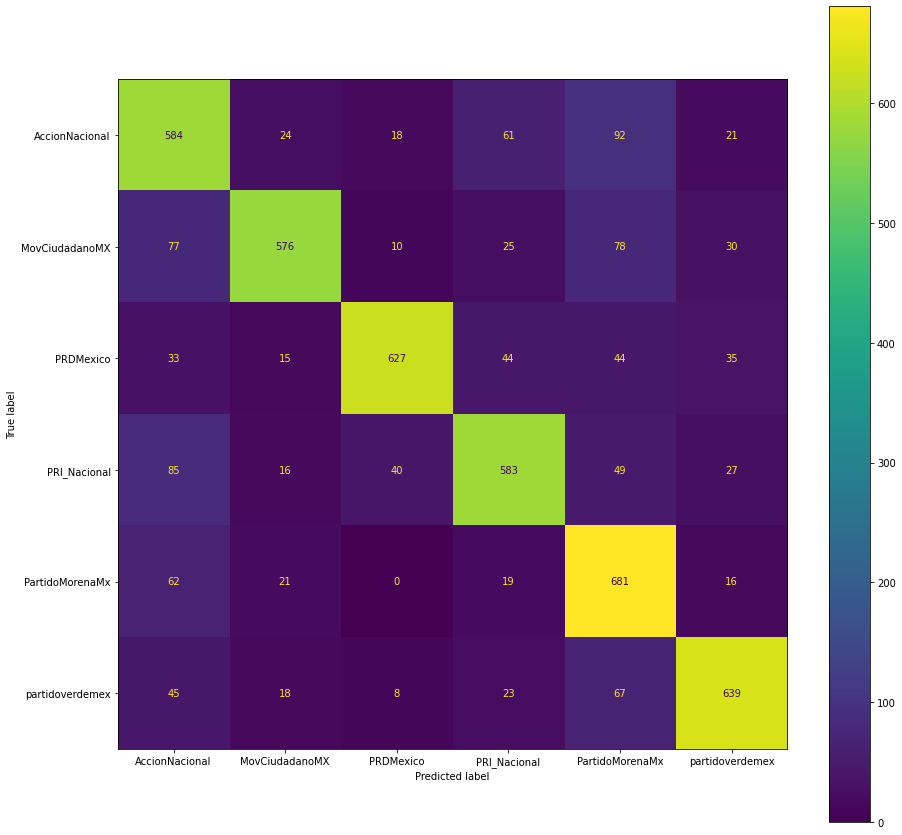

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this DecisionTree Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_dtc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_precision = precision_score(y_test, cvec_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_precision

0.7814237969222394

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_recall = recall_score(y_test, cvec_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_recall

0.7698579617348917

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_f1 = f1_score(y_test, cvec_dtc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_f1

0.7718991909075402

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_dtc_gs.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

### CountVectorizer + ExtraTreesClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Extra Trees Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_etc_pipe = make_pipeline(CountVectorizer(), ExtraTreesClassifier())
cvec_etc_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'extratreesclassifier': ExtraTreesClassifier(),
 'extratreesclassifier__bootstrap': False,
 'extratreesclassifier__ccp_alpha': 0.0,
 'extratreesclassifier__class_weight': None,
 'extratreesclassifier__criterion': 'gini',
 'extratreesclassifier__max_depth': None,
 'extratreesclassifier__max_fea

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_etc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'extratreesclassifier__max_depth': [None, 5, 10, 15, 20],
    'extratreesclassifier__max_features': [None, 1_000, 2_000],
    'extratreesclassifier__min_samples_split': [2, 3, 4],
    'extratreesclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_etc_rs = RandomizedSearchCV(cvec_etc_pipe, param_distributions=cvec_etc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_rs.fit(X_train, y_train)
cvec_etc_rs.score(X_train, y_train), cvec_etc_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic'

(0.9961741791875348, 0.7623617775923222)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_etc_rs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_etc_new_params = {
    'countvectorizer__ngram_range': [(3,3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'extratreesclassifier__max_depth': [None],
    'extratreesclassifier__max_features': [1000],
    'extratreesclassifier__min_samples_split': [3],
    'extratreesclassifier__n_estimators': [140, 150, 160]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_etc_gs = GridSearchCV(cvec_etc_pipe, param_grid=cvec_etc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_gs.fit(X_train, y_train)
cvec_etc_gs.score(X_train, y_train), cvec_etc_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ejempl', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'except', 'exist', 'explic', 'expres', 'fuer

(0.9961741791875348, 0.7642395159607761)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_etc_gs_preds".
cvec_etc_gs_preds = cvec_etc_gs.predict(X_test)

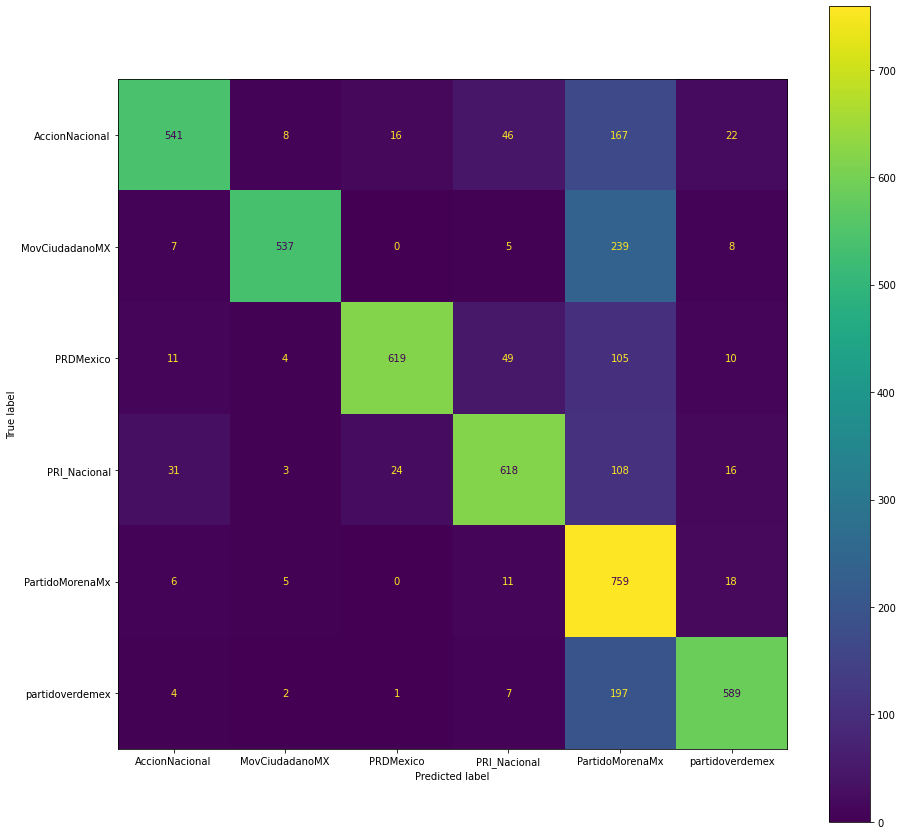

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this ExtraTreesClassifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_etc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_precision = precision_score(y_test, cvec_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_precision

0.8350257100549285

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_recall = recall_score(y_test, cvec_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_recall

0.7642082934021258

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_f1 = f1_score(y_test, cvec_etc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_f1

0.7773158115149256

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_etc_gs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

### CountVectorizer + RandomForestClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Random Forest Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_rfc_pipe = make_pipeline(CountVectorizer(), RandomForestClassifier())
cvec_rfc_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'memory': None,
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_rfc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__max_features': [None, 1_000, 2_000],
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_rfc_rs = RandomizedSearchCV(cvec_rfc_pipe, param_distributions=cvec_rfc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_rs.fit(X_train, y_train)
cvec_rfc_rs.score(X_train, y_train), cvec_rfc_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic'

(0.9961741791875348, 0.730857500521594)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_rfc_rs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_rfc_new_params = {
    'countvectorizer__ngram_range': [(3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__max_features': [1000],
    'randomforestclassifier__min_samples_split': [2],
    'randomforestclassifier__n_estimators': [90, 100, 110]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_rfc_gs = GridSearchCV(cvec_rfc_pipe, param_grid=cvec_rfc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_gs.fit(X_train, y_train)
cvec_rfc_gs.score(X_train, y_train), cvec_rfc_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bastant', 'brev', 'cad', 'cerc', 'ciert', 'cinc', 'clar', 'coment', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ejempl', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'except', 'exist', 'explic', 'expres', 'fuer

(0.9961046188091264, 0.7300229501356145)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_rfc_gs_preds".
cvec_rfc_gs_preds = cvec_rfc_gs.predict(X_test)

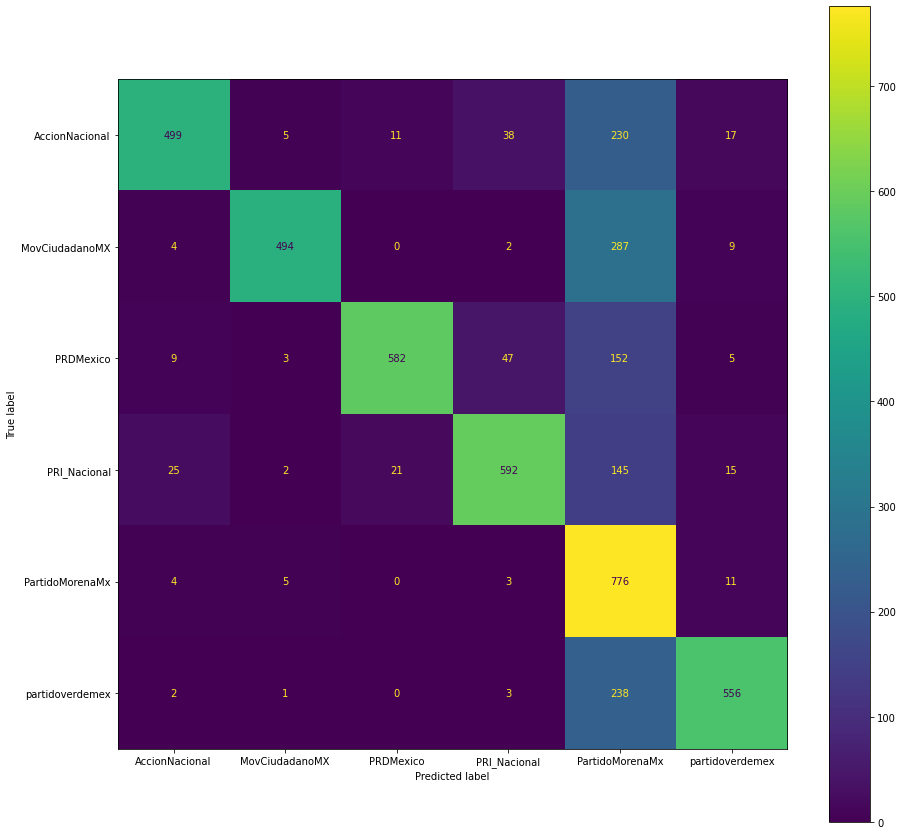

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this RandomForestClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_rfc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_precision = precision_score(y_test, cvec_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_precision

0.8385391327940157

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_recall = recall_score(y_test, cvec_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_recall

0.7299817234779927

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_f1 = f1_score(y_test, cvec_rfc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_f1

0.7498426488306241

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_rfc_gs.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

### CountVectorizer + GradientBoostingClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Gradient Boosting Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_gbc_pipe = make_pipeline(CountVectorizer(), GradientBoostingClassifier())
cvec_gbc_pipe.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'gradientboostingclassifier': GradientBoostingClassifier(),
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss'

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_gbc_params = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'gradientboostingclassifier__max_depth': [None, 5, 10, 15, 20],
    'gradientboostingclassifier__max_features': [None, 1_000, 2_000],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_gbc_rs = RandomizedSearchCV(cvec_gbc_pipe, param_distributions=cvec_gbc_params, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_rs.fit(X_train, y_train)
cvec_gbc_rs.score(X_train, y_train), cvec_gbc_rs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar',

(0.9956872565386756, 0.8787815564364698)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_gbc_rs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_gbc_new_params = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [frozenset(spanish)],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'gradientboostingclassifier__max_depth': [15],
    'gradientboostingclassifier__max_features': [2_000],
    'gradientboostingclassifier__min_samples_split': [2],
    'gradientboostingclassifier__n_estimators': [140, 150, 160]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_gbc_gs = GridSearchCV(cvec_gbc_pipe, param_grid=cvec_gbc_new_params, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_gs.fit(X_train, y_train)
cvec_gbc_gs.score(X_train, y_train), cvec_gbc_gs.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufeff1'] not in stop_words.
  % sorted(inconsistent)


(0.9958263772954925, 0.8771124556645108)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_gbc_gs_preds".
cvec_gbc_gs_preds = cvec_gbc_gs.predict(X_test)

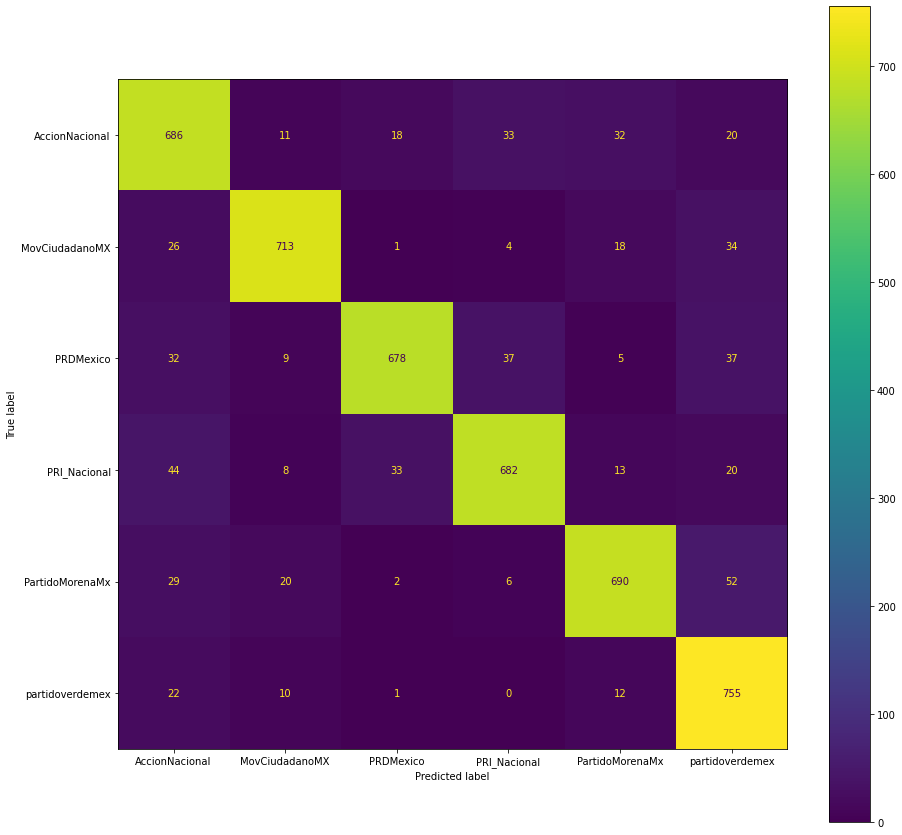

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this GradientBoostingClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_gbc_gs, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_precision = precision_score(y_test, cvec_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_precision

0.8801560116537553

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_recall = recall_score(y_test, cvec_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_recall

0.8771136962848974

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_f1 = f1_score(y_test, cvec_gbc_gs_preds, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_f1

0.8774200152591293

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_gbc_gs.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            'a',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
            'anterior',
            'antes',
            'apenas',
            'aproximadamente',
            'aquel',
            'aquella',
            'aq

## **CountVectorizer with Spanish + Party and Politican Stop Words**

### CountVectorizer + Logistic Regression

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Logistic Regression classifier with a max_iter of 10_000.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_logreg_pipe_sw = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=10_000))
cvec_logreg_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'logisticregression': LogisticRegression(max_iter=10000),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_logreg_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer], 
    'logisticregression__C': [1.0, .1],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet']
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_logreg_rs_sw = RandomizedSearchCV(cvec_logreg_pipe_sw, param_distributions=cvec_logreg_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_rs_sw.fit(X_train, y_train)
cvec_logreg_rs_sw.score(X_train, y_train), cvec_logreg_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pack

(0.9933917640511964, 0.8696015021906948)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_logreg_rs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_logreg_new_params_sw = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [lemma_tokenizer], 
    'logisticregression__C': [1.0, .8, .6],
    'logisticregression__penalty': ['l2']
}

**Hyperparameter Tuning using GridSearch CV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_logreg_gs_sw = GridSearchCV(cvec_logreg_pipe_sw, param_grid=cvec_logreg_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_logreg_gs_sw.fit(X_train, y_train)
cvec_logreg_gs_sw.score(X_train, y_train), cvec_logreg_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'avilesalvarez', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'democrático', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'lopezobrador', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'moreno', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufe

(0.9933917640511964, 0.8696015021906948)

In [ ]:
# Utilized the fitted GridSearchCV object to predict the target and saved the results under variable named "cvec_logreg_gs_preds_sw".
cvec_logreg_gs_preds_sw = cvec_logreg_gs_sw.predict(X_test)

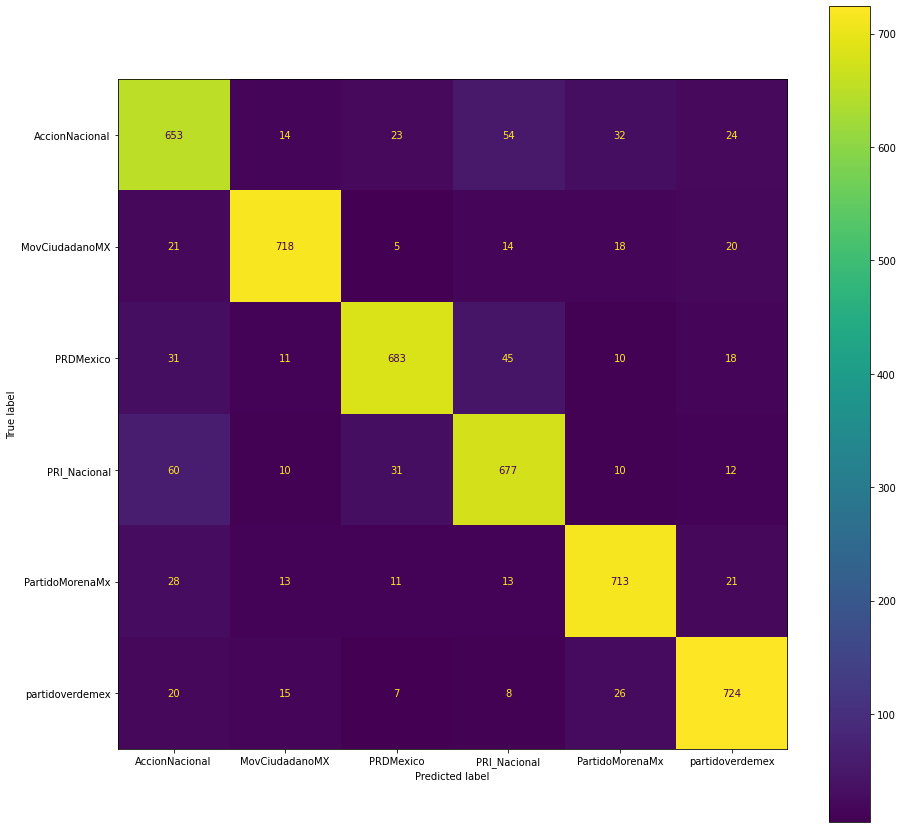

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this Logistic Regression estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_logreg_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_precision_sw = precision_score(y_test, cvec_logreg_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_precision_sw

0.8702213635782888

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_recall_sw = recall_score(y_test, cvec_logreg_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_recall_sw

0.8696275385638432

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_logreg_gs_f1_sw = f1_score(y_test, cvec_logreg_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_logreg_gs_f1_sw

0.8697821923341347

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_logreg_gs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + KNeighborsClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and KNeighbors classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_knn_pipe_sw = make_pipeline(CountVectorizer(), KNeighborsClassifier())
cvec_knn_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'kneighborsclassifier': KNeighborsClassifier(),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neigh

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_knn_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'kneighborsclassifier__n_neighbors': [2, 5, 10]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_knn_rs_sw = RandomizedSearchCV(cvec_knn_pipe_sw, param_distributions=cvec_knn_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_rs_sw.fit(X_train, y_train)
cvec_knn_rs_sw.score(X_train, y_train), cvec_knn_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'avilesalvarez', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'democrático', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'lopezobrador', 'manifestar', 

(0.7085420144685587, 0.5472564156060922)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_knn_rs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_knn_new_params_sw = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'kneighborsclassifier__n_neighbors': [4, 5, 6]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_knn_gs_sw = GridSearchCV(cvec_knn_pipe_sw, param_grid=cvec_knn_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_knn_gs_sw.fit(X_train, y_train)
cvec_knn_gs_sw.score(X_train, y_train), cvec_knn_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'avilesalvarez', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'democrático', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'lopezobrador', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'moreno', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufe

(0.733166388425153, 0.5522637179219695)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_knn_gs_preds_sw".
cvec_knn_gs_preds_sw = cvec_knn_gs_sw.predict(X_test)

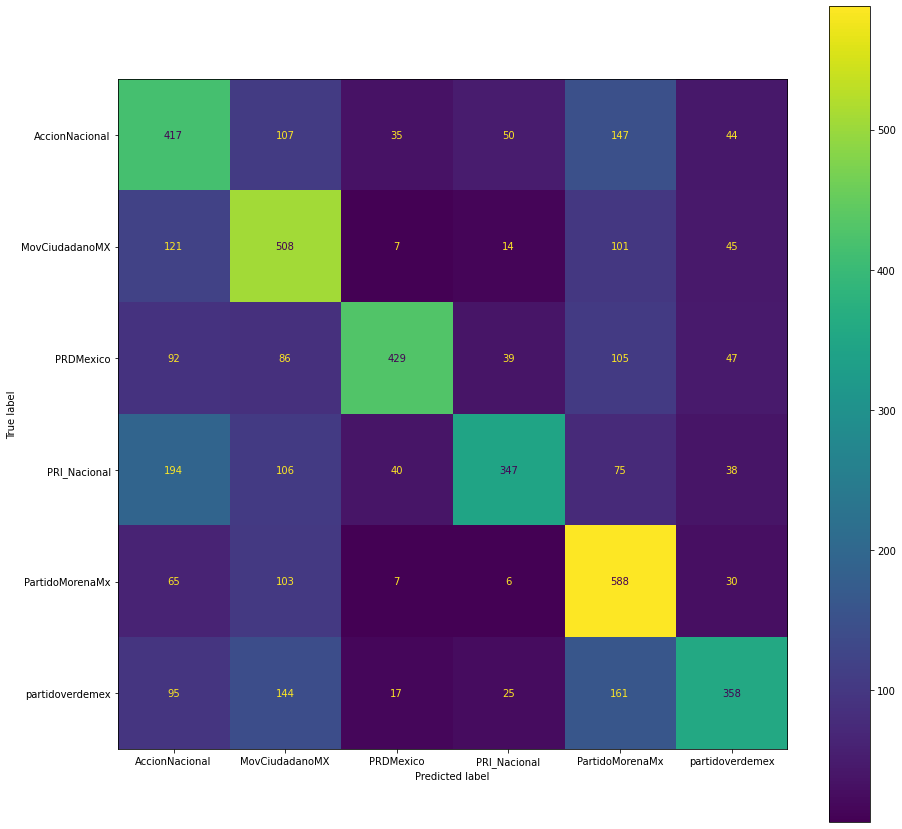

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this KNeighbors Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_knn_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_precision_sw = precision_score(y_test, cvec_knn_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_precision_sw

0.594270444992128

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_recall_sw = recall_score(y_test, cvec_knn_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_recall_sw

0.5523674732685198

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_knn_gs_f1_sw = f1_score(y_test, cvec_knn_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_knn_gs_f1_sw

0.5538237240689791

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_knn_gs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + SVC

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Support Vector Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_svc_pipe_sw = make_pipeline(CountVectorizer(), SVC())
cvec_svc_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'memory': None,
 'steps': [('countvectorizer', CountVectorizer()), ('svc', SVC())],
 'svc': SVC(),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scal

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_svc_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'svc__C': [1.0, .1]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_svc_rs_sw = RandomizedSearchCV(cvec_svc_pipe_sw, param_distributions=cvec_svc_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_rs_sw.fit(X_train, y_train)
cvec_svc_rs_sw.score(X_train, y_train), cvec_svc_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', '

(0.9924179187534781, 0.659712080116837)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_svc_rs_sw.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_svc_new_params_sw = {
    'countvectorizer__ngram_range': [(3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'svc__C': [1.0, .8, .6]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_svc_gs_sw = GridSearchCV(cvec_svc_pipe_sw, param_grid=cvec_svc_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_svc_gs_sw.fit(X_train, y_train)
cvec_svc_gs_sw.score(X_train, y_train), cvec_svc_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'democrat', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ecolog', 'ejempl', 'elfuturoesnaranj', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'e

(0.9924179187534781, 0.659712080116837)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_svc_gs_preds_sw".
cvec_svc_gs_preds_sw = cvec_svc_gs_sw.predict(X_test)

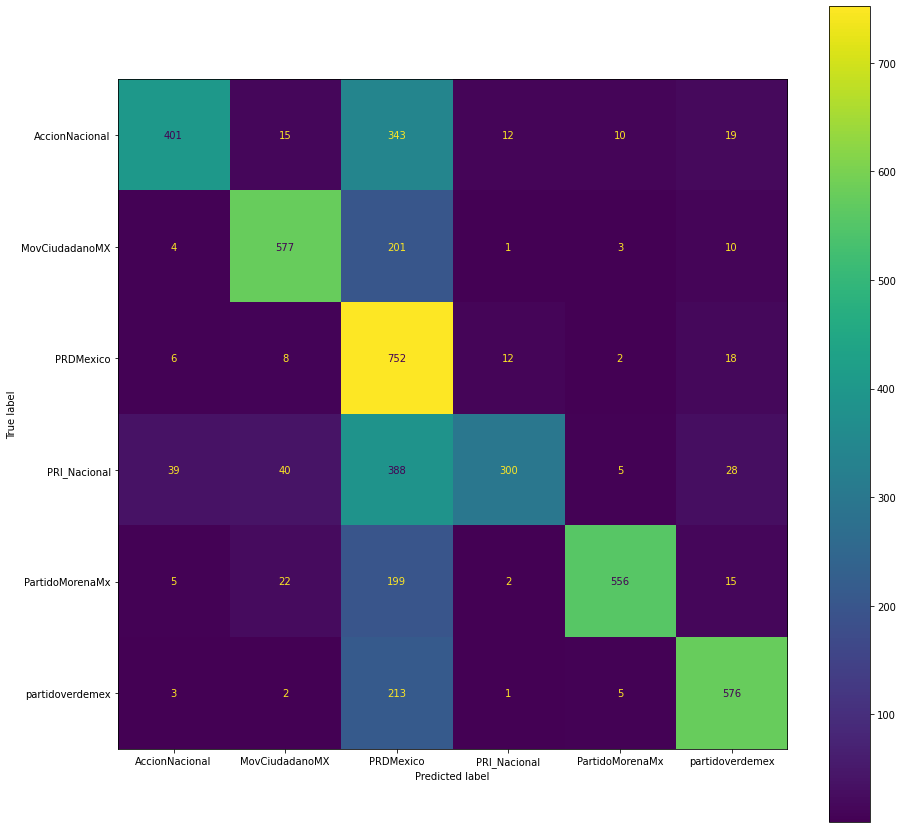

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this SVC estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_svc_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_precision_sw = precision_score(y_test, cvec_svc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_precision_sw

0.8066283554011063

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_recall_sw = recall_score(y_test, cvec_svc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_recall_sw

0.6598916831467047

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_svc_gs_f1_sw = f1_score(y_test, cvec_svc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_svc_gs_f1_sw

0.6785250803314343

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_svc_gs_sw.best_params_

{'countvectorizer__ngram_range': (3, 3),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + MultinomialNB

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Multinomial Naives Bayes Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_mnb_pipe_sw = make_pipeline(CountVectorizer(), MultinomialNB())
cvec_mnb_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'memory': None,
 'multinomialnb': MultinomialNB(),
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False}

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_mnb_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'multinomialnb__alpha': [1.0, .5, .1]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_mnb_rs_sw = RandomizedSearchCV(cvec_mnb_pipe_sw, param_distributions=cvec_mnb_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_rs_sw.fit(X_train, y_train)
cvec_mnb_rs_sw.score(X_train, y_train), cvec_mnb_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', '

(0.9957568169170841, 0.8773210932610056)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_mnb_rs_sw.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_mnb_new_params_sw = {
    'countvectorizer__ngram_range': [(2, 2)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'multinomialnb__alpha': [0.1, 0.05, 0.01]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_mnb_gs_sw = GridSearchCV(cvec_mnb_pipe_sw, param_grid=cvec_mnb_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_mnb_gs_sw.fit(X_train, y_train)
cvec_mnb_gs_sw.score(X_train, y_train), cvec_mnb_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'democrat', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ecolog', 'ejempl', 'elfuturoesnaranj', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'e

(0.9957568169170841, 0.8773210932610056)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_mnb_gs_preds".
cvec_mnb_gs_preds_sw = cvec_mnb_gs_sw.predict(X_test)

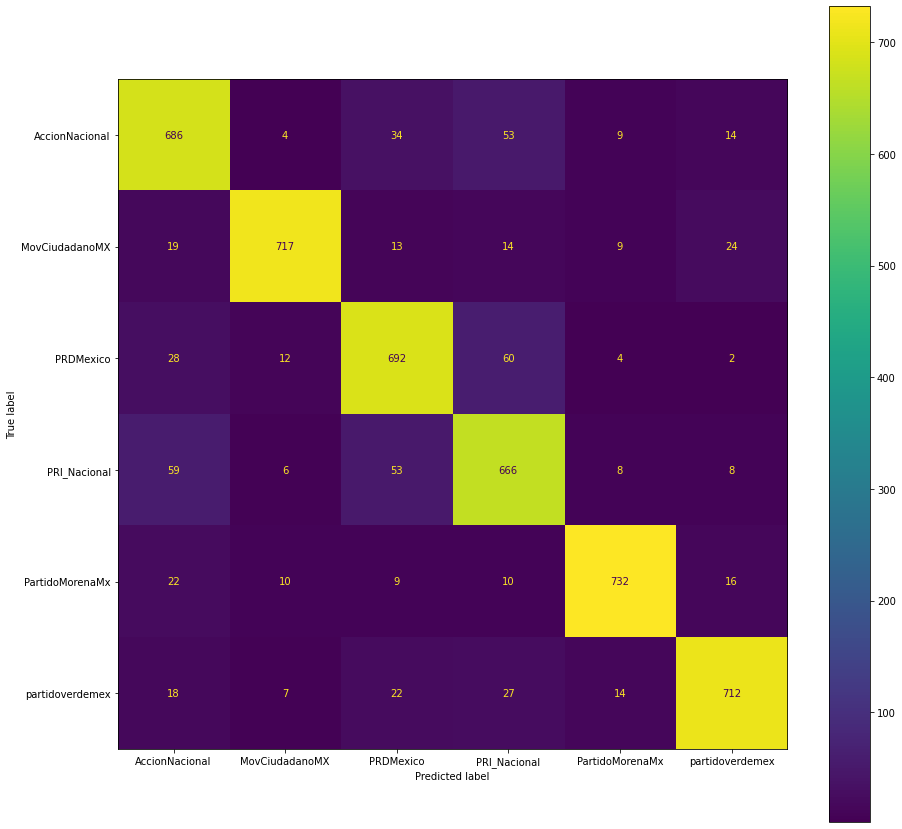

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this MNB Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_mnb_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_precision_sw = precision_score(y_test, cvec_mnb_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_precision_sw

0.879498759241281

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_recall_sw = recall_score(y_test, cvec_mnb_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_recall_sw

0.8773444783534275

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_mnb_gs_f1_sw = f1_score(y_test, cvec_mnb_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_mnb_gs_f1_sw

0.878117387358424

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_mnb_gs_sw.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + DecisionTreeClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Decision Tree Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_dtc_pipe_sw = make_pipeline(CountVectorizer(), DecisionTreeClassifier())
cvec_dtc_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreec

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_dtc_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__max_features': [None, 1_000, 2_000],
    'decisiontreeclassifier__min_samples_split': [None, 2, 5]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_dtc_rs_sw = RandomizedSearchCV(cvec_dtc_pipe_sw, param_distributions=cvec_dtc_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_rs_sw.fit(X_train, y_train)
cvec_dtc_rs_sw.score(X_train, y_train), cvec_dtc_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pack

(0.9585420144685587, 0.6824535781347799)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_dtc_rs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_dtc_new_params_sw = {
    'countvectorizer__ngram_range': [(1,1)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None],
    'decisiontreeclassifier__max_depth': [None],
    'decisiontreeclassifier__max_features': [1000],
    'decisiontreeclassifier__min_samples_split': [4, 5, 6]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_dtc_gs_sw = GridSearchCV(cvec_dtc_pipe_sw, param_grid=cvec_dtc_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_dtc_gs_sw.fit(X_train, y_train)
cvec_dtc_gs_sw.score(X_train, y_train), cvec_dtc_gs_sw.score(X_test, y_test)

(0.967237061769616, 0.6786981013978719)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_dtc_gs_preds_sw".
cvec_dtc_gs_preds_sw = cvec_dtc_gs_sw.predict(X_test)

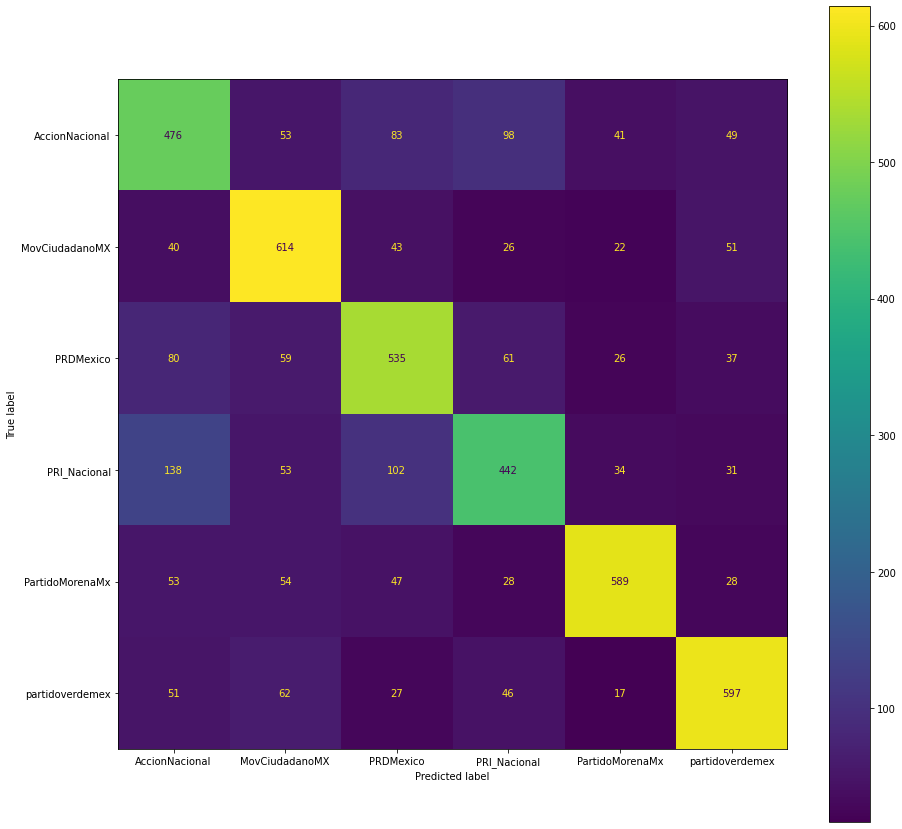

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this DecisionTree Classifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_dtc_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_precision_sw = precision_score(y_test, cvec_dtc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_precision_sw

0.6807602392612009

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_recall_sw = recall_score(y_test, cvec_dtc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_recall_sw

0.6787840522354864

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_dtc_gs_f1_sw = f1_score(y_test, cvec_dtc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_dtc_gs_f1_sw

0.6785401088339437

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_dtc_gs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + ExtraTreesClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Extra Trees Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_etc_pipe_sw = make_pipeline(CountVectorizer(), ExtraTreesClassifier())
cvec_etc_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'extratreesclassifier': ExtraTreesClassifier(),
 'extratreesclassifier__bootstrap': False,
 'extratreesclassifier__ccp_alpha': 0.0,
 'extratreesclassifier__class_weight': None,
 'extratreesclassifier__criterion': 'gini',
 'extratreesclassifier__max_depth': None,
 'extratreesclassifier__max_fea

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_etc_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'extratreesclassifier__max_depth': [None, 5, 10, 15, 20],
    'extratreesclassifier__max_features': [None, 1_000, 2_000],
    'extratreesclassifier__min_samples_split': [2, 3, 4],
    'extratreesclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_etc_rs_sw = RandomizedSearchCV(cvec_etc_pipe_sw, param_distributions=cvec_etc_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_rs_sw.fit(X_train, y_train)
cvec_etc_rs_sw.score(X_train, y_train), cvec_etc_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', '

(0.9962437395659433, 0.7905278531191321)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_etc_rs_sw.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_etc_new_params_sw = {
    'countvectorizer__ngram_range': [(2,2)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'extratreesclassifier__max_depth': [None],
    'extratreesclassifier__max_features': [2000],
    'extratreesclassifier__min_samples_split': [3, 4, 5],
    'extratreesclassifier__n_estimators': [100]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_etc_gs_sw = GridSearchCV(cvec_etc_pipe_sw, param_grid=cvec_etc_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_etc_gs_sw.fit(X_train, y_train)
cvec_etc_gs_sw.score(X_train, y_train), cvec_etc_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'democrat', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ecolog', 'ejempl', 'elfuturoesnaranj', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'e

(0.9962437395659433, 0.7947006050490298)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_etc_gs_preds_sw".
cvec_etc_gs_preds_sw = cvec_etc_gs_sw.predict(X_test)

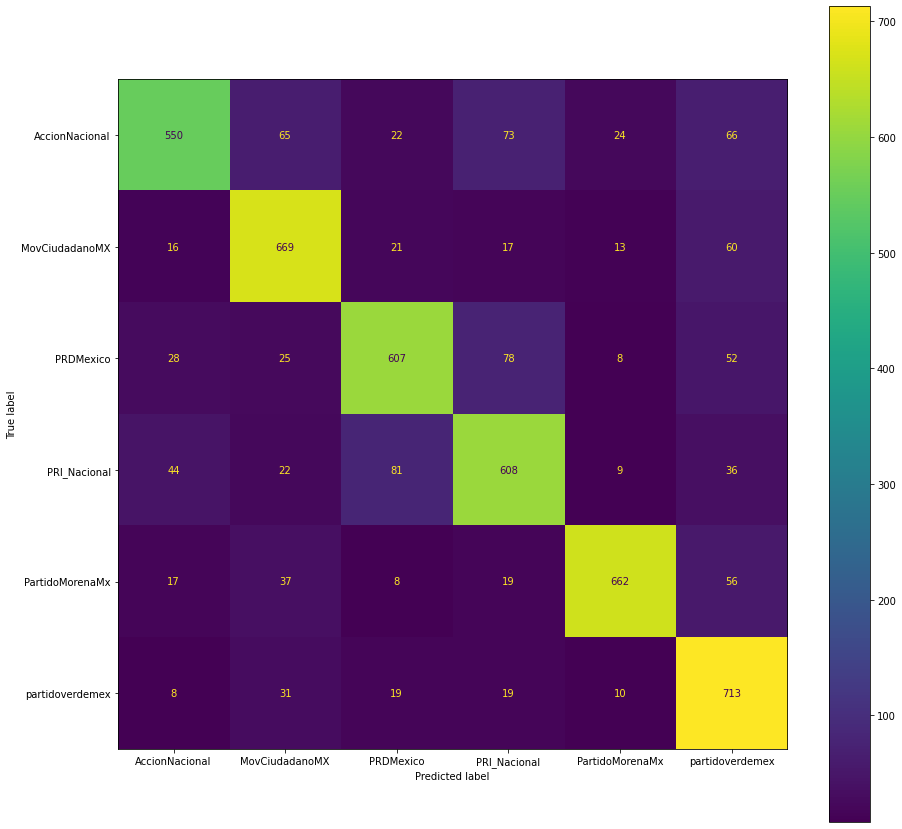

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this ExtraTreesClassifier estimator.

# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_etc_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_precision_sw = precision_score(y_test, cvec_etc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_precision_sw

0.8004075190377873

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_recall_sw = recall_score(y_test, cvec_etc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_recall_sw

0.7947315933276998

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_etc_gs_f1_sw = f1_score(y_test, cvec_etc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_etc_gs_f1_sw

0.7944732130077256

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_etc_gs_sw.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + RandomForestClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Random Forest Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_rfc_pipe_sw = make_pipeline(CountVectorizer(), RandomForestClassifier())
cvec_rfc_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'memory': None,
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_rfc_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__max_features': [None, 1_000, 2_000],
    'randomforestclassifier__min_samples_split': [2, 3, 4],
    'randomforestclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_rfc_rs_sw = RandomizedSearchCV(cvec_rfc_pipe_sw, param_distributions=cvec_rfc_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_rs_sw.fit(X_train, y_train)
cvec_rfc_rs_sw.score(X_train, y_train), cvec_rfc_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'democrat', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ecolog', 'ejempl', 'elfuturoesnaranj', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'e

(0.7134112409571508, 0.6764030878364281)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_rfc_rs_sw.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_rfc_new_params_sw = {
    'countvectorizer__ngram_range': [(2, 2)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [stemming_tokenizer],
    'randomforestclassifier__max_depth': [15],
    'randomforestclassifier__max_features': [1000],
    'randomforestclassifier__min_samples_split': [3],
    'randomforestclassifier__n_estimators': [140, 150, 160]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_rfc_gs_sw = GridSearchCV(cvec_rfc_pipe_sw, param_grid=cvec_rfc_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_rfc_gs_sw.fit(X_train, y_train)
cvec_rfc_gs_sw.score(X_train, y_train), cvec_rfc_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['accion', 'actual', 'acuerd', 'adel', 'adem', 'adred', 'afirm', 'agreg', 'ahor', 'algun', 'ample', 'antan', 'antañ', 'apen', 'aproxim', 'aqu', 'aquell', 'arrib', 'arribaabaj', 'asegur', 'aunqu', 'añad', 'baj', 'bancadanaranj', 'bastant', 'brev', 'cad', 'caroviggian', 'cerc', 'ciert', 'cinc', 'ciudadan', 'clar', 'coment', 'conferenciapresident', 'conmig', 'conoc', 'consegu', 'consider', 'consig', 'contig', 'contr', 'cos', 'cre', 'cualqui', 'cuand', 'cuant', 'cuatr', 'cuent', 'dad', 'deb', 'debaj', 'dec', 'dej', 'delant', 'demas', 'demasi', 'democrat', 'dentr', 'depris', 'desd', 'despaci', 'despu', 'detr', 'dic', 'dich', 'diferent', 'dij', 'dond', 'durant', 'ecolog', 'ejempl', 'elfuturoesnaranj', 'embarg', 'emple', 'encim', 'encuentr', 'enfrent', 'ensegu', 'entonc', 'eram', 'estab', 'estam', 'e

(0.720575959933222, 0.6853745044857084)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_rfc_gs_preds".
cvec_rfc_gs_preds_sw = cvec_rfc_gs_sw.predict(X_test)

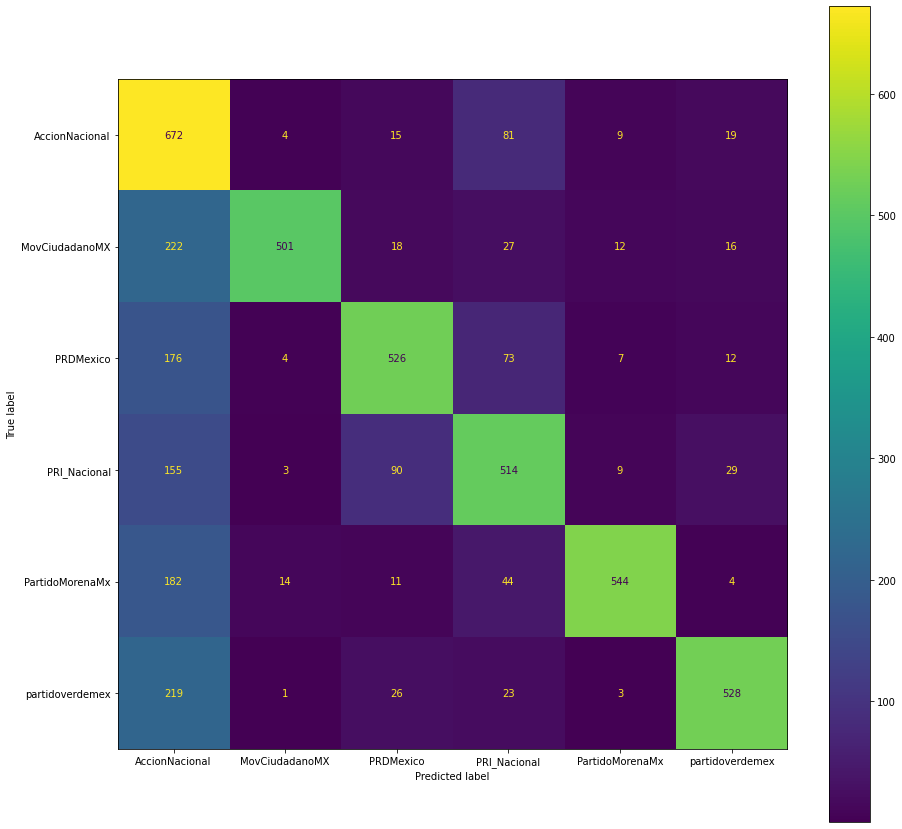

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this RandomForestClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_rfc_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_precision_sw = precision_score(y_test, cvec_rfc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_precision_sw

0.7675301170369276

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_recall_sw = recall_score(y_test, cvec_rfc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_recall_sw

0.685315986404766

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_rfc_gs_f1_sw = f1_score(y_test, cvec_rfc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_rfc_gs_f1_sw

0.7025148392508758

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_rfc_gs_sw.best_params_

{'countvectorizer__ngram_range': (2, 2),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

### CountVectorizer + GradientBoostingClassifier

In [ ]:
# Created a pipeline object with a CountVectorizer transformer and Gradient Boosting Classifier.  Proceeded to get a list of all available hyperparameters using the .get_params() method.
cvec_gbc_pipe_sw = make_pipeline(CountVectorizer(), GradientBoostingClassifier())
cvec_gbc_pipe_sw.get_params()

{'countvectorizer': CountVectorizer(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'gradientboostingclassifier': GradientBoostingClassifier(),
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss'

In [ ]:
# Created a dictionary of hyperparameter ranges that I would then perform a RandomizedSearchCV over.
cvec_gbc_params_sw = {
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [None, lemma_tokenizer, stemming_tokenizer],
    'gradientboostingclassifier__max_depth': [None, 5, 10, 15, 20],
    'gradientboostingclassifier__max_features': [None, 1_000, 2_000],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4],
    'gradientboostingclassifier__n_estimators': [100, 150, 200]
}

**Hyperparameter Tuning using RandomizedSearchCV**

In [ ]:
# Created a RandomizedSerachCV object that contained the pipeline and the dictionary of hyperparameter ranges I had created and ensured that the jobs ran in parallel.
cvec_gbc_rs_sw = RandomizedSearchCV(cvec_gbc_pipe_sw, param_distributions=cvec_gbc_params_sw, n_jobs=-1)

In [ ]:
# Fit this RandomizedSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_rs_sw.fit(X_train, y_train)
cvec_gbc_rs_sw.score(X_train, y_train), cvec_gbc_rs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'avilesalvarez', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'democrático', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'lopezobrador', 'manifestar', 

(0.9956176961602671, 0.8693928645941998)

In [ ]:
# Looked at the hyperparameters identified as best by the RandomizedSearchCV.
cvec_gbc_rs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

In [ ]:
# Proceeded to create a new parameter grid that continaed a narrow range around the results obtained from the RandomizedSearchCV.
cvec_gbc_new_params_sw = {
    'countvectorizer__ngram_range': [(1, 1)],
    'countvectorizer__stop_words': [frozenset(spanish_politics)],
    'countvectorizer__tokenizer': [lemma_tokenizer],
    'gradientboostingclassifier__max_depth': [15],
    'gradientboostingclassifier__max_features': [1_000],
    'gradientboostingclassifier__min_samples_split': [2],
    'gradientboostingclassifier__n_estimators': [140, 150, 160]
}

**Hyperparameter Tuning using GridSearchCV**

In [ ]:
# Created a GridSerachCV object that contained the pipeline along with the revised dictionary of hyperparameter ranges that surrounded the hyperparameters identified as optimal by the RandomizedSearchCV and ensured that the jobs ran in parallel.
cvec_gbc_gs_sw = GridSearchCV(cvec_gbc_pipe_sw, param_grid=cvec_gbc_new_params_sw, n_jobs=-1)

In [ ]:
# Fit this GridSearchCV object on X_train and y_train before scoring both X_train, y_train and X_test, y_test.
cvec_gbc_gs_sw.fit(X_train, y_train)
cvec_gbc_gs_sw.score(X_train, y_train), cvec_gbc_gs_sw.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acordar', 'adelantar', 'ademar', 'afirmar', 'agregar', 'apenar', 'arribar', 'asegurar', 'asir', 'avilesalvarez', 'añadir', 'bajar', 'cercar', 'cincar', 'comentar', 'comer', 'considerar', 'contar', 'coser', 'creer', 'cualquiera', 'deber', 'dejar', 'demasiar', 'democrático', 'do', 'embargar', 'encimar', 'encontrar', 'enfrentar', 'entrar', 'erar', 'existir', 'explicar', 'expresar', 'gramo', 'grande', 'hablar', 'haz', 'hemo', 'hora', 'indicar', 'informar', 'juntar', 'largar', 'litro', 'llegar', 'lopezobrador', 'manifestar', 'mediar', 'mencionar', 'metro', 'miar', 'moreno', 'nadar', 'parecer', 'parir', 'pasar', 'página', 'quedar', 'querer', 'raro', 'respectar', 'salir', 'salvar', 'seguir', 'segundar', 'señalar', 'sobrar', 'suponer', 'tardar', 'tercero', 'tratar', 'ultimar', 'unir', 'vario', '\ufe

(0.9957568169170841, 0.8693928645941998)

In [ ]:
# Utilized the fitted pipeline object to predict the target and saved the results under variable named "cvec_gbc_gs_preds_sw".
cvec_gbc_gs_preds_sw = cvec_gbc_gs_sw.predict(X_test)

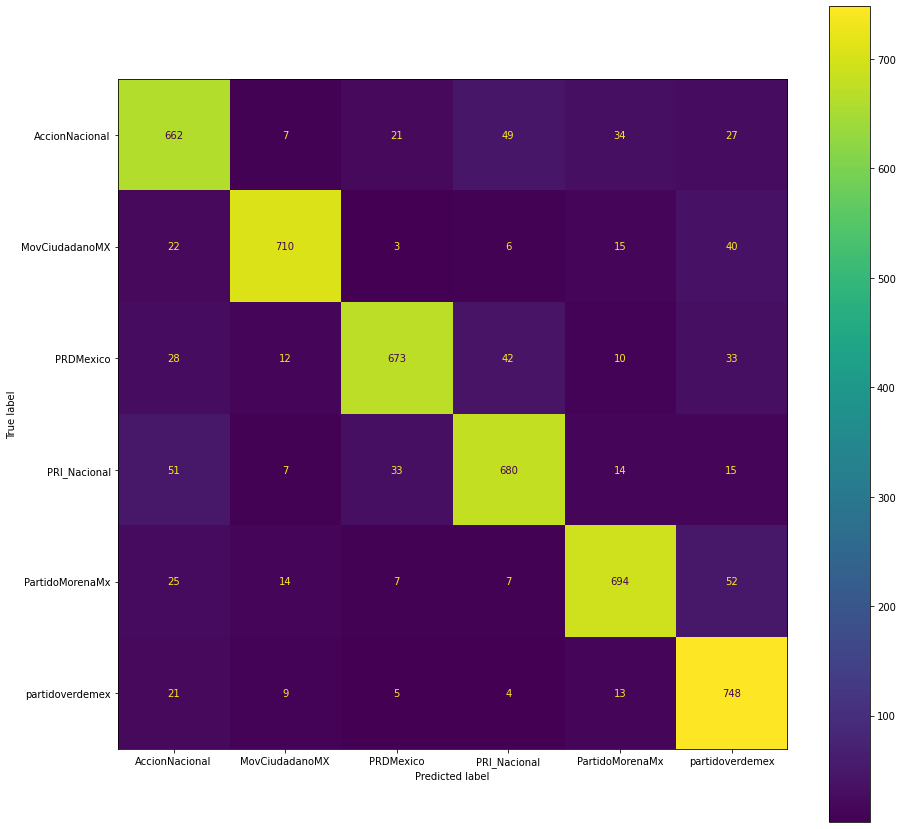

In [ ]:
# Generated a ConfusionMatrixDisplay utilizing this GradientBoostingClassifier estimator.
# Obtained guidance with size from: https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(cvec_gbc_gs_sw, X_test, y_test, ax=ax);

In [ ]:
# Calcualted the precision score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_precision_sw = precision_score(y_test, cvec_gbc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_precision_sw

0.8718196229689612

In [ ]:
# Calcualted the recall score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_recall_sw = recall_score(y_test, cvec_gbc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_recall_sw

0.8694006545250259

In [ ]:
# Calcualted the f1 score after setting 'PartidoMorenaMx' as the positive label.
cvec_gbc_gs_f1_sw = f1_score(y_test, cvec_gbc_gs_preds_sw, labels='PartidoMorenaMx', average='macro')
cvec_gbc_gs_f1_sw

0.8696407247757117

In [ ]:
# Looked at the hyperparameters identified as best by the GridSearchCV.
cvec_gbc_gs_sw.best_params_

{'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': frozenset({'0',
            '1',
            '2',
            '22',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9',
            '_',
            '_avilesalvarez',
            'a',
            'accionnacional',
            'acción',
            'actualmente',
            'acuerdo',
            'adelante',
            'ademas',
            'además',
            'adrede',
            'afirmó',
            'agregó',
            'ahi',
            'ahora',
            'ahí',
            'al',
            'algo',
            'alguna',
            'algunas',
            'alguno',
            'algunos',
            'algún',
            'alitomorenoc',
            'alli',
            'allí',
            'alrededor',
            'ambos',
            'amlo',
            'ampleamos',
            'antano',
            'antaño',
            'ante',
         

# **Evaluation of Best Model: CountVectorizer with Spanish Stop Words List and Multinomial Naive Bayes Classifier**

In [28]:
# Expanding the number of characters Pandas will display in a column:
pd.options.display.max_colwidth = 325

In [29]:
# Transforming dtype of user to integer
user_map = {
    'partidoverdemex' : 0,
    'PRI_Nacional' : 1,
    'AccionNacional' : 2, 
    'PartidoMorenaMx' : 3, 
    'PRDMexico' : 4, 
    'MovCiudadanoMX': 5
}

In [30]:
y_test_encoded = y_test.map(user_map)
y_test_encoded

10800    0
2695     2
6868     4
6753     4
6007     1
        ..
4889     1
3910     1
16301    3
6348     1
18964    3
Name: user, Length: 4793, dtype: int64

In [31]:
incorrect_classifications = pd.DataFrame(X_test)[y_test != cvec_mnb_gs_preds]
incorrect_classifications

,tweet
17865,"Un tabasqueño que anhelaba el cambio, que desde aquel entonces llamaba la atención de México. Ese tabasqueño hoy es el mejor presidente que ha tenido México. https://t.co/cAhoQGgi4z"
7442,Agradecemos y reconocemos a las enfermeras y enfermeros que durante más de dos años de pandemia demostraron lo fundamental que es su labor para México. #DíaDeLaEnfermería https://t.co/p0t228N2O7
18522,La transformación en Michoacán permite hacer inversiones históricas para recuperar la paz en el estado y apoyar a la población más necesitada https://t.co/yfyrXAfUgU
3665,RT @_AvilesAlvarez: En cada lugar que recorremos encontramos el respaldo y el cariño de la gente. ¡Gracias #Miahuatlán! Mi compromiso con u…
1066,"En un ejercicio de total transparencia, damos a conocer los resultados de las encuestas firmadas y acordadas bilateralmente entre los principales aspirantes a la gubernatura de Aguascalientes. Como ellos mismos acordaron ante el desacuerdo habrá consulta indicativa con militancia https://t.co/LHLGKqwjjz"
...,...
6567,"Sigamos reconociendo la labor de la Marina Nacional para la defensa de México, gracias por su servicio al país. #DíaDeLaMarina #DíaDeLaMarinaNacional https://t.co/tei5IfqSGp"
860,El gobierno de Panamá se ha comportado a la altura negando el beneplácito a un presunto acosador sexual. \n\n@lopezobrador_ nuevamente se equivoca con su propuesta. \n\nEl @senadomexicano tiene que revisar exhaustivamente cada perfil antes de ser ratificado.
18346,Hoy recordamos a Andrés Henestrosa por su aporte invaluable a la letras mexicanas y su labor por engrandecer la diversidad de nuestra tierra. https://t.co/gJUFzqBmbF
13021,"Ninguna promesa de desarrollo es sostenible cuando contamina el agua, por eso le decimos NO al #TrenMaya. ❌🚞 https://t.co/ZnMtbViePl"


In [32]:
correct_classifications = pd.DataFrame(X_test)[y_test == cvec_mnb_gs_preds]
correct_classifications

,tweet
10800,Celebramos el nombramiento de Tomás Gloria como Coordinador Nacional del Campo en el Partido Verde; su amplia experiencia en el sector es avalada con más de 30 años de trabajo en favor de la gente del campo. https://t.co/8SavXs6are
2695,"Lamentamos profundamente el fallecimiento de Antonio González González, padre de nuestro querido amigo y compañero @Felipe0465, secretario nacional de Comunicación. Enviamos nuestras más sentidas condolencias a sus familiares y seres queridos. Descanse en paz. https://t.co/KTG81Sw7tk"
6868,RT @Jesus_ZambranoG: En la #CDMX estamos ante un grave retroceso antidemocrático porque #Morena quiere hacer modificaciones al Código Elec…
6753,¡Faltan 8 días! Para un #NuevoAmanecer en #Oaxaca. El próximo 5 de junio vota por el #TripleAGobernador #VotaPRD ☀️ vota por @_AvilesAlvarez. https://t.co/7DlSllH7Ca
6007,"El priismo de Tlaxcala, encabezado por @marcoamena, ha dado excelentes resultados a la población, por ello con @AnabelAvalosTlx vamos a seguir por la ruta del desarrollo, ahora #UnidosPorTlaxcala con @accionnacional, el @prdmexico, el @pac_estatal y el #PS.\n#AnabellGobernadora https://t.co/JuvsbZejKY"
...,...
4889,A través de https://t.co/ws039A5tGZ han llegado miles de propuestas e ideas para definir el rumbo de nuestro partido. ¡Participa! #Revolucionarios https://t.co/DAV6WUVmCq
3910,"Con las mejores propuestas y los mejores candidatos, ¡este 2022 los #Revolucionarios vamos con todo para ganar! https://t.co/BSWXeHKPuK"
16301,"""Nos deben explicaciones, Calderón y todos ellos (...), de manera cínica se habla ahora (...) de la violencia en México, como si esto hubiese surgido de la nada"": presidente @lopezobrador_ \n\n#ConferenciaPresidente https://t.co/6qPjeSZOmC"
6348,"Si le decimos adiós a los organismos autónomos, también le decimos adiós a la posibilidad de que haya empleo para todos, incluso para los más preparados. #MorenaDestruye https://t.co/cIkGettPGR"
